In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time

import logging
logging.basicConfig(level=logging.INFO)

In [3]:
import qt3utils.experiments.rabi
from qt3utils.analysis.rabi import signal_to_background
import qt3utils.analysis.aggregation
import qt3utils.nidaq
import qcsapphire
import qt3rfsynthcontrol

In [4]:
pulser = qcsapphire.Pulser('COM10')
rfsynth = qt3rfsynthcontrol.QT3SynthHD('COM5')

In [5]:
nidaq_config = qt3utils.nidaq.EdgeCounter('Dev1')

In [6]:
rabi = qt3utils.experiments.rabi.Rabi(pulser, rfsynth, nidaq_config, rf_width_high = 10e-6, rf_power = -20)

In [7]:
rabi.experimental_conditions()

{'rf_width_low': 4e-07,
 'rf_width_high': 1e-05,
 'rf_width_step': 2e-07,
 'rf_power': -20,
 'rf_frequency': 2870000000.0,
 'aom_width': 3e-06,
 'aom_response_time': 8e-07,
 'post_rf_pad': 1e-06,
 'pre_rf_pad': 0,
 'clock_period': 2e-07}

In [8]:
#rabi.rf_power = -10
#rabi.aom_width = 5e-6
#rabi.rf_width_high = 10e-6
#rabi.rf_width_low = .4e-6
rabi.rf_width_step = .2e-6
#rabi.rf_frequency = 2593e6
#rabi.rf_frequency = 2700e6

In [9]:
def aggregate_mean_data(data_buffer, rabi):
    '''
    Calls qt3utils.analysis.aggregation.reshape_sum_trace, where
        cwodmr.N_cycles = N_rows
        cwodmr.N_clock_ticks_per_cycle = N_samples_per_row

    '''
    return qt3utils.analysis.aggregation.reshape_mean_trace(data_buffer,
                                                           rabi.N_cycles,
                                                           rabi.N_clock_ticks_per_cycle)

In [30]:
scan_data = rabi.run(N_cycles = 400000, post_process_function=aggregate_mean_data)

INFO:qt3utils.experiments.rabi:RF Width: 4e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 6e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 8e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 1e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 1.2e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 1.4e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 1.6e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 1.8e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 2e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 2.2e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 2.4e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 2.6e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 2.8e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 3e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 3.2e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 3.4e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 3.6e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 3.

In [31]:
def plot_rolled_trace(trace, N_cycles=1, clock_rate=1, shift=0):
    trace = np.roll(trace,shift)
    plt.plot(np.arange(len(trace)) / clock_rate, trace/N_cycles * clock_rate)

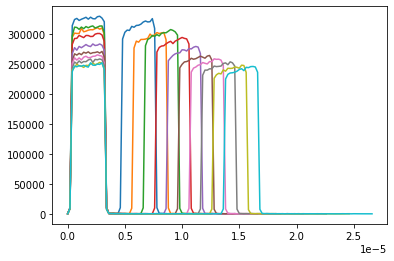

In [32]:
for scan in scan_data[::5]:
    plot_rolled_trace(scan[-1], clock_rate = 1/rabi.clock_period)

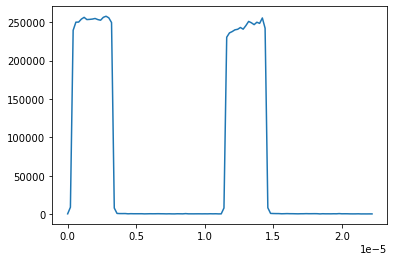

In [33]:

scan = scan_data[34]
plot_rolled_trace(scan[-1], clock_rate = 1/rabi.clock_period)

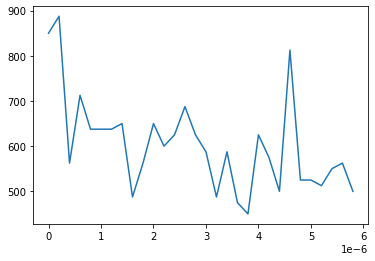

In [34]:
plot_rolled_trace(scan[-1][20:50], clock_rate = 1/rabi.clock_period)

In [14]:
def signal_to_background(trace, pre_trigger, aom_width, rf_width, post_rf_pad, verbose=False,
                        signal_aom_width_duty = 1.0, background_aom_width_duty = 1.0,
                        aggregation = np.sum):
    '''
    Assumes trace produced by qt3utils.experiments.rabi.Rabi class and
    is the aggregated data for a particular RF width.

    The inputs `pre_trigger`, `aom_width` and `rf_width` are all in units of index of the trace.
    That is, they are in units of clock ticks.

    Assumes that trace is of shape
        * pre_trigger
        * aom_width: aom on / rf off (background)
        * rf_width:  aom off / rf on
        * aom_width: aom on/ rf off  (signal)

    returns sum(signal) / sum(background)

    '''
    background_end = pre_trigger + int(aom_width*background_aom_width_duty)
    signal_start = pre_trigger + aom_width + rf_width + post_rf_pad
    signal_end = signal_start + int(aom_width*signal_aom_width_duty)

    background = aggregation(trace[pre_trigger:background_end])
    signal = aggregation(trace[signal_start:signal_end])

    if verbose:
        print('background')
        print(trace[pre_trigger:background_end])
        print('signal')
        print(trace[signal_start:signal_end])

    return signal / background



In [15]:
# scan = scan_data[5]
# rf_width_time = scan[0]
# N_samples_per_cycle = scan[1]
# clock_period = rabi.clock_period
# aom_width_time = rabi.aom_width
# summed_trace = scan[2]
# print(summed_trace)
# aom_width_ticks = np.round(aom_width_time / clock_period).astype(int)
# rf_width_ticks = np.round(rf_width_time / clock_period).astype(int)

# signal_to_background(summed_trace, pre_trigger, 
#                            aom_width_ticks, rf_width_ticks, aom_width_duty = 0.5, verbose= True)


In [16]:
rabi.experimental_conditions()

{'rf_width_low': 4e-07,
 'rf_width_high': 1e-05,
 'rf_width_step': 2e-07,
 'rf_power': -20,
 'rf_frequency': 2870000000.0,
 'aom_width': 3e-06,
 'aom_response_time': 8e-07,
 'post_rf_pad': 1e-06,
 'pre_rf_pad': 0,
 'clock_period': 2e-07}

In [35]:
rabi.experimental_conditions()

{'rf_width_low': 4e-07,
 'rf_width_high': 1e-05,
 'rf_width_step': 2e-07,
 'rf_power': -20,
 'rf_frequency': 2870000000.0,
 'aom_width': 3e-06,
 'aom_response_time': 8e-07,
 'post_rf_pad': 1e-06,
 'pre_rf_pad': 0,
 'clock_period': 2e-07}

In [36]:
contrast = []
pre_trigger = 2
#pre_trigger = 3
for scan in scan_data:
    
    rf_width_time = scan[0]
    N_samples_per_cycle = scan[1]
    clock_period = rabi.clock_period
    aom_width_time = rabi.aom_width
    summed_trace = scan[2]
    
    aom_width_ticks = np.round(aom_width_time / clock_period).astype(int)
    rf_width_ticks = np.round(rf_width_time / clock_period).astype(int)
    post_rf_pad_ticks = np.round(rabi.post_rf_pad / clock_period).astype(int)

    c = signal_to_background(summed_trace, 
                             pre_trigger, 
                             aom_width_ticks, 
                             rf_width_ticks, 
                             post_rf_pad_ticks,
                             signal_aom_width_duty = 0.75, 
                             background_aom_width_duty = 0.75 )
    
    contrast.append([rf_width_time, c]) 

contrast = np.array(contrast)

In [37]:
x_data = contrast[:, 0]*1e6
y_data = contrast[:, 1]


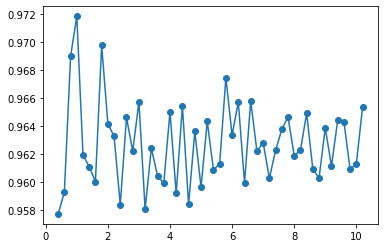

In [38]:
plt.plot(x_data, y_data, 'o-', label='Data')

In [26]:
rabi.set_pulser_state(400e-9)
pulser.system.state(1)

'ok'

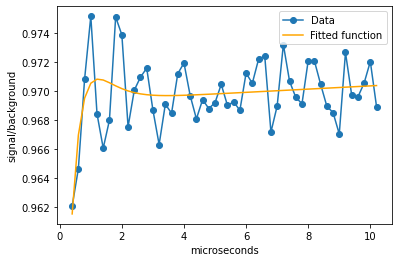

In [20]:
from scipy import optimize


def rabi_oscillation(x, a, b, phi, t, offset, slope):
    return a * np.exp(-x/t) * np.sin(x/b + phi) + offset + slope * x

params, params_covariance = optimize.curve_fit(rabi_oscillation, x_data, y_data,
                                              p0=[.005, 1, 1, 1, 1, 0], maxfev=50000)
#params, params_covariance = optimize.curve_fit(rabi_oscillation, x_data, y_data, maxfev=5000)


plt.figure(figsize=(6, 4))
#plt.scatter(x_data, y_data, label='Data', s=5)
plt.plot(x_data, y_data, 'o-', label='Data')

plt.xlabel('microseconds')
plt.ylabel('signal/background')
plt.plot(x_data, rabi_oscillation(x_data, *params),
         label='Fitted function', color='orange')
plt.legend()